In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
# https://drive.google.com/drive/folders/13_RRUcgCo7_53sIOlPJDAZ4o_oKxox5Y?usp=share_link
url='13_RRUcgCo7_53sIOlPJDAZ4o_oKxox5Y'
gdd.download_file_from_google_drive(file_id=url,dest_path='./data.zip',unzip=True)

Unzipping...

/usr/local/lib/python3.9/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "13_RRUcgCo7_53sIOlPJDAZ4o_oKxox5Y" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


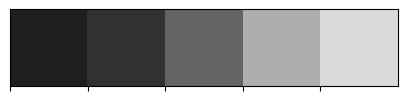

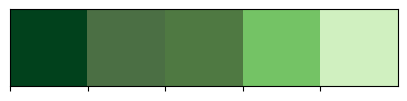

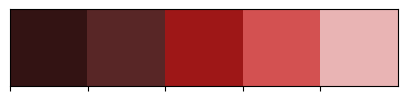

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join("/content/drive/MyDrive/Btp Dataset",'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Btp Dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:16<00:00,  4.39it/s]


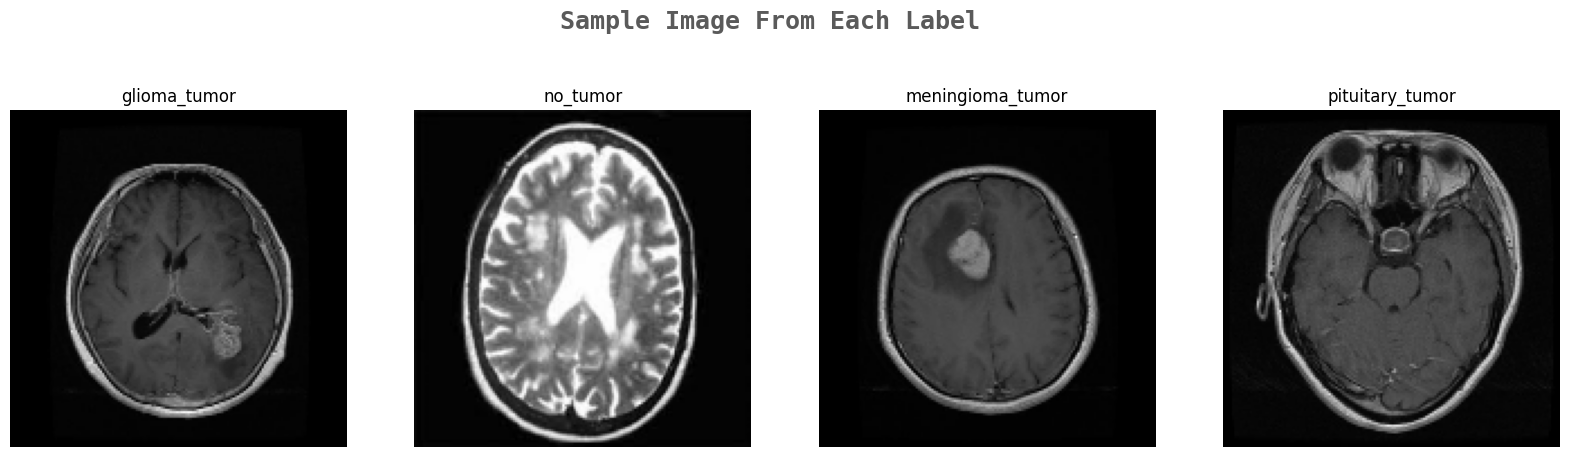

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)


In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, batch_size=32,
                   callbacks=[checkpoint,reduce_lr])

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.7007
Epoch 1: val_accuracy improved from -inf to 0.15306, saving model to effnet.h5
83/83 [==============================] - 73s 234ms/step - loss: 0.9044 - accuracy: 0.7007 - val_loss: 83.1156 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8865
Epoch 2: val_accuracy improved from 0.15306 to 0.79252, saving model to effnet.h5
83/83 [==============================] - 15s 185ms/step - loss: 0.3476 - accuracy: 0.8865 - val_loss: 0.5272 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9436
Epoch 3: val_accuracy did not improve from 0.79252
83/83 [==============================] - 14s 174ms/step - loss: 0.1589 - accuracy: 0.9436 - val_loss: 0.6917 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 4/20
83/83 [==============================] - ETA: 0s - loss: 0.

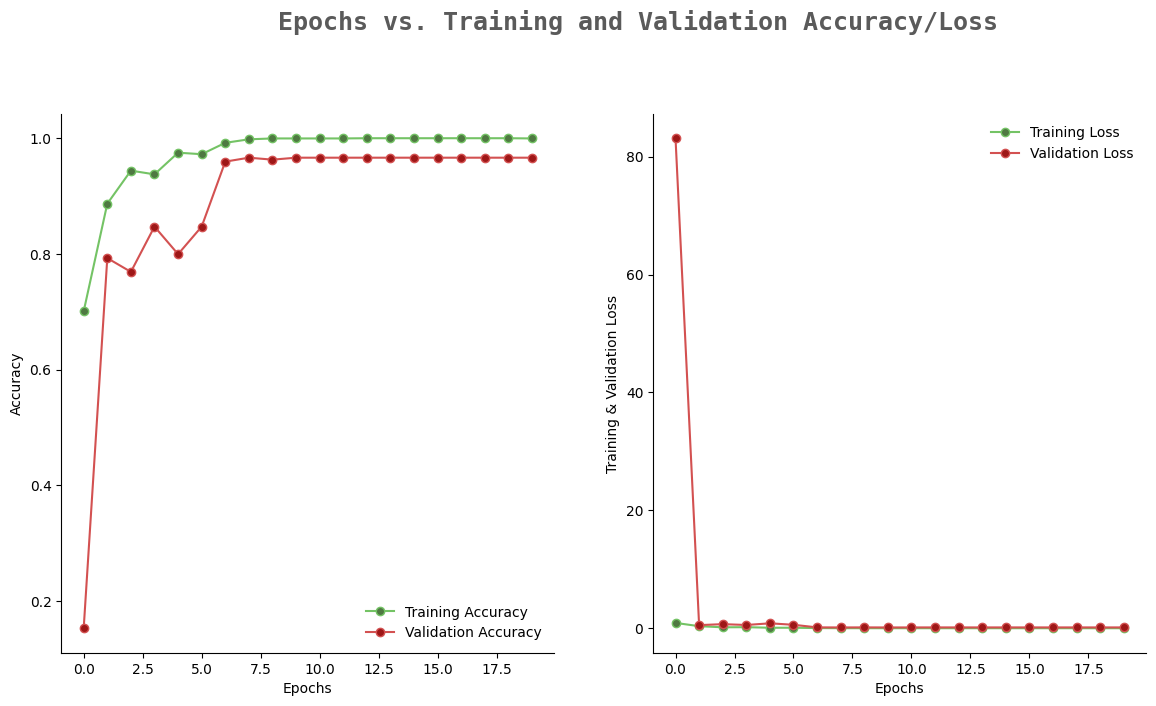

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 119ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        93
           1       0.96      0.96      0.96        51
           2       0.96      0.97      0.96        96
           3       0.97      0.98      0.97        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



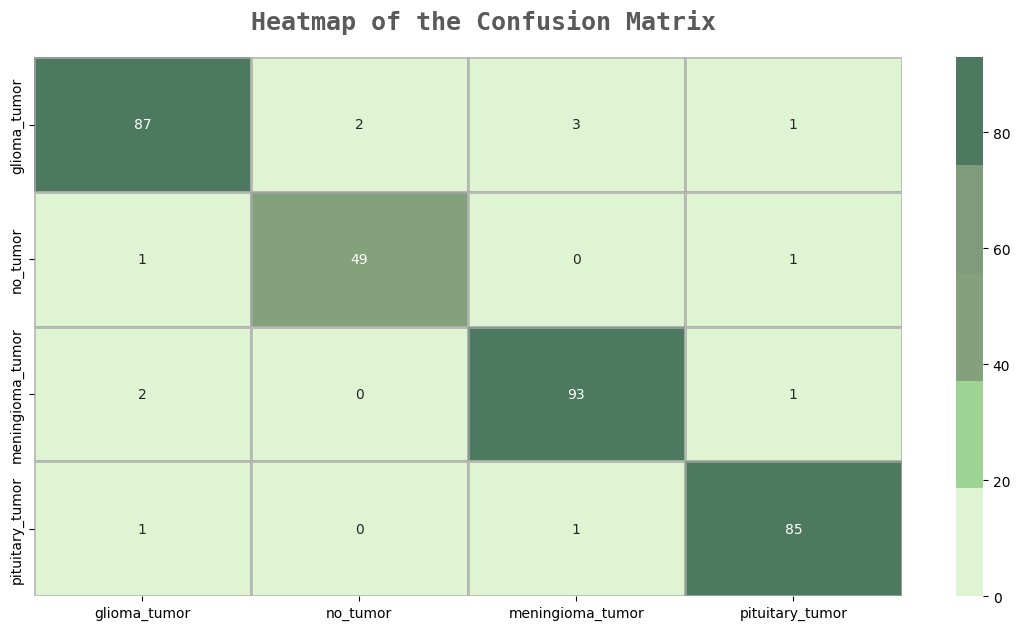

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
print(accuracy_score(y_test_new,pred))

0.9602446483180428


In [47]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [1]:
uploader = widgets.FileUpload()
display(uploader)


NameError: ignored

In [52]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            content = uploader.value[list(uploader.value.keys())[0]]['content']
            img = Image.open(io.BytesIO(content))
            img.show()
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])